In [1]:
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, fbeta_score
from sklearn.model_selection import train_test_split, ParameterGrid

import matplotlib.pyplot as plt
import seaborn as sns

from ast import literal_eval

Preview data

In [2]:
# Check all embeddings
preview = pd.read_parquet('../b__data-collection-with-web-scraping/datasets/train_test/NL_embeddings.parquet')

In [3]:
# Test DF for pre-processing functions
test = preview[:10].copy()

Set data structure

In [4]:
# Countries of interest for this project
countries = ['NL', 'UK']

# Set data structure to store data and facilitate analysis           
country_data = {
    'NL': {
        'embeddings': None,
        'unknown_embeddings': None,
        'Y': None,
        'splits': {
            'train': None,
            'dev': None,
            'test': None,
            'final_train': None
        },
        'embedders': {}  
    },
    'UK': {
        'embeddings': None,
        'unknown_embeddings': None,
        'Y': None,
        'splits': {
            'train': None,
            'dev': None,
            'test': None,
            'final_train': None
        },
        'embedders': {}
    }
}

# Embedders to test
embedding_models = [
    'VGG-Face',
    'Facenet',
    'Facenet512',
    'OpenFace',
    #'DeepFace',
    'ArcFace',
    'Dlib',
    'SFace',
    'face_recognition'
]

# DF columns
embeddings_cols = ['embedding_' + embedder for embedder in embedding_models]

# UNKNOWN_LABEL
unknown_label = 99

#### Pre-processing functions

In [5]:
def check_duplicate_embeddings(df, country, cols):
    """
    Duplicates appearing in both training and test set is undesirable;
    it may corrupt the process. Therefore, they are removed from the data. 
    """
    df_cleaned = df.copy()
    duplicates_removed = {}
    for col in cols:
            duplicate_mask = df_cleaned[col].duplicated(keep='first')
            duplicate_rows = df_cleaned[duplicate_mask]
            
            if not duplicate_rows.empty:
                num_duplicates = len(duplicate_rows)
                df_cleaned = df_cleaned[~df_cleaned.index.isin(duplicate_rows.index)]
                duplicates_removed[col] = num_duplicates
            else:
                continue

    print(f"\n=== Duplicate report for {country} ===")
    for col, count in duplicates_removed.items():
        print(f"Removed {count} duplicates")

    print(f"Original shape: {df.shape}")
    print(f"Cleaned shape: {df_cleaned.shape}")
    print('_ ' * 16)
    return df_cleaned

In [6]:
def print_split_sizes(country_data):
    """
    Function that facilitates inspection of the dataset sizes
    """
    for country in ['NL', 'UK']:
        print(f"\n=== {country} Split Sizes ===")
        splits = country_data[country]['splits']
        
        # Calculate sizes of the splits
        train_size = len(splits['train'])
        dev_size = len(splits['dev'])
        test_size = len(splits['test'])
        
        # Count of unknowns in dev set
        dev_politicians = sum(splits['dev']['politician'] != 'Unknown')
        dev_unknowns = sum(splits['dev']['politician'] == 'Unknown')
        test_politicians = sum(splits['test']['politician'] != 'Unknown')
        test_unknowns = sum(splits['test']['politician'] == 'Unknown')
        
        # Print report
        print(f"Training Politicians: {train_size}")
        print(f"Development Set: {dev_size} ({dev_politicians} politicians, {dev_unknowns} unknowns)")
        print(f"Test Set: {test_size} ({test_politicians} politicians, {test_unknowns} unknowns)")
        print(f"Total Samples: {train_size + dev_size + test_size}")

Test functions

In [7]:
test.head()

,country,politician,image_path,embedding_VGG-Face,embedding_Facenet,embedding_Facenet512,embedding_OpenFace,embedding_ArcFace,embedding_Dlib,embedding_SFace,embedding_face_recognition
0,NL,Stephan_van_Baarle,datasets/train_test/NL/Stephan_van_Baarle/7518...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0343820583382...","[0.2907654643058777, 0.5678703784942627, -0.59...","[-0.8811557292938232, 1.1285032033920288, -0.4...","[0.015059384517371655, 0.006262484472244978, -...","[-0.14670303463935852, 0.11384416371583939, -0...","[-0.053955599665641785, 0.09319762885570526, 0...","[-0.7423117756843567, 0.5515708327293396, 1.04...","[-0.08167310059070587, 0.02302662841975689, 0...."
1,NL,Stephan_van_Baarle,datasets/train_test/NL/Stephan_van_Baarle/b5c4...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0109293536791...","[0.01734083890914917, 1.0677095651626587, 0.36...","[-1.9518992900848389, 1.1397768259048462, 0.94...","[-0.02600262314081192, 0.004551914054900408, -...","[-0.18038032948970795, 0.279319167137146, -0.2...","[-0.05004735663533211, 0.0352143831551075, 0.0...","[-0.9400857090950012, -0.5621656775474548, 0.3...","[-0.07158689945936203, 0.050367504358291626, 0..."
2,NL,Stephan_van_Baarle,datasets/train_test/NL/Stephan_van_Baarle/6711...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0565274535416...","[1.2932127714157104, -0.6363705396652222, 1.16...","[-0.5140327215194702, 0.7249234914779663, 0.14...","[0.02915845438838005, 0.06930511444807053, 0.0...","[-0.0846487358212471, 0.38507404923439026, -0....","[-0.0722360759973526, -0.0019726187456399202, ...","[-0.8447213768959045, -0.5323300957679749, 1.1...","[-0.06998300552368164, 0.07013103365898132, 0...."
3,NL,Stephan_van_Baarle,datasets/train_test/NL/Stephan_van_Baarle/034f...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07389121...","[-0.5141052007675171, -0.14589416980743408, -0...","[-0.4285900294780731, 0.46602827310562134, -0....","[0.10006731003522873, -0.0619647316634655, 0.0...","[-0.1664310246706009, 0.3704061508178711, 0.01...","[0.0012769631575793028, 0.06571324914693832, 0...","[1.1664515733718872, 0.22525428235530853, -0.1...","[-0.07564379274845123, 0.11386445164680481, 0...."
4,NL,Stephan_van_Baarle,datasets/train_test/NL/Stephan_van_Baarle/307a...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.310562402009964, 0.8564702272415161, -0.965...","[-0.9611704349517822, 0.8630242943763733, 0.04...","[-0.0113795455545187, 0.0975126326084137, -0.0...","[-0.10379300266504288, 0.14741967618465424, 0....","[-0.03182348236441612, 0.06024117395281792, 0....","[-0.1440213918685913, -0.03564627841114998, 1....","[-0.036771029233932495, 0.04112560674548149, 0..."


In [8]:
"""
Expected result:
VGG-Face: 4096 dimensions | Sample values: [0. 0. 0.]
Facenet: 128 dimensions | Sample values: [ 0.29076546  0.56787038 -0.59804821]
Facenet512: 512 dimensions | Sample values: [-0.88115573  1.1285032  -0.42154071]
OpenFace: 128 dimensions | Sample values: [ 0.01505938  0.00626248 -0.08118218]
ArcFace: 512 dimensions | Sample values: [-0.14670303  0.11384416 -0.16587548]
Dlib: 128 dimensions | Sample values: [-0.0539556   0.09319763  0.01774417]
SFace: 128 dimensions | Sample values: [-0.74231178  0.55157083  1.04793072]
face_recognition: 128 dimensions | Sample values: [-0.0816731   0.02302663  0.07031105]
"""
preview = test.filter(like='embedding_').copy()
for col in preview.columns:
    sample_embedding = preview[col].dropna().iloc[0]
    
    print(f"{col.replace('embedding_','')}: {len(sample_embedding)} dimensions | Sample values: {sample_embedding[:3]}")

VGG-Face: 4096 dimensions | Sample values: [0. 0. 0.]
Facenet: 128 dimensions | Sample values: [ 0.29076546  0.56787038 -0.59804821]
Facenet512: 512 dimensions | Sample values: [-0.88115573  1.1285032  -0.42154071]
OpenFace: 128 dimensions | Sample values: [ 0.01505938  0.00626248 -0.08118218]
ArcFace: 512 dimensions | Sample values: [-0.14670303  0.11384416 -0.16587548]
Dlib: 128 dimensions | Sample values: [-0.0539556   0.09319763  0.01774417]
SFace: 128 dimensions | Sample values: [-0.74231178  0.55157083  1.04793072]
face_recognition: 128 dimensions | Sample values: [-0.0816731   0.02302663  0.07031105]


In [9]:
preview[embeddings_cols] = preview[embeddings_cols].map(lambda x: np.array(x) if isinstance(x, (list, np.ndarray)) else np.nan)

In [10]:
preview['embedding_VGG-Face'][:-1].ndim

1

#### Create data structure

Creating the data structure takes approximately 3m35s

In [11]:
# Load and process data for each country
for country in countries:
    # Load data
    embeddings_dup = pd.read_parquet(f'../b__data-collection-with-web-scraping/datasets/train_test/{country}_embeddings.parquet')
    unknown_embeddings_dup = pd.read_parquet(f'../b__data-collection-with-web-scraping/datasets/train_test/{country}_unknown_embeddings.parquet')
    
    # Check duplicates
    embeddings = check_duplicate_embeddings(embeddings_dup, country, embeddings_cols)
    unknown_embeddings = check_duplicate_embeddings(unknown_embeddings_dup, f'{country} Unknown', embeddings_cols)

    # Convert to numpy arrays
    for col in embeddings_cols:
        # Filter out rows where the embedding is not a list or has an invalid dimension
        embeddings = embeddings[embeddings[col].apply(lambda x: isinstance(x, (list, np.ndarray)) and len(x) > 1)]
        unknown_embeddings = unknown_embeddings[unknown_embeddings[col].apply(lambda x: isinstance(x, (list, np.ndarray)) and len(x) > 1)]

        # Numpy mapping
        embeddings[col] = embeddings[col].map(lambda x: np.array(x))
        unknown_embeddings[col] = unknown_embeddings[col].map(lambda x: np.array(x))

    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(embeddings['politician'])
    embeddings['politician_encoded'] = y
    embeddings['politician'] = embeddings['politician']
    unknown_embeddings['politician_encoded'] = 99
    unknown_embeddings['politician'] = 'Unknown'
    
    # Store in dictionary
    country_data[country]['embeddings'] = embeddings
    country_data[country]['Y'] = y
    country_data[country]['label_encoder'] = label_encoder
    country_data[country]['politician'] = label_encoder.classes_
    country_data[country]['unknown_embeddings'] = unknown_embeddings
    country_data[country]['Y_unknown'] = np.full(len(unknown_embeddings), 99)
    
    # Create splits
    train_data, dev_data = train_test_split(embeddings, test_size=0.4, random_state=2)
    dev_data = pd.concat([dev_data, unknown_embeddings])
    dev_data, test_data = train_test_split(dev_data, test_size=0.5, random_state=2)
    
    # Store splits
    country_data[country]['splits'] = {
        'train': train_data,
        'dev': dev_data,
        'test': test_data
    }
    
    # Extract and store each embedding type with names
    for model in embedding_models:
        col_name = f'embedding_{model}'
        country_data[country]['embedders'][model] = {
            'train': {
                'X': train_data[col_name],
                'y': train_data['politician_encoded'].tolist(),
                'politician': train_data['politician'].tolist()
            },
            'dev': {
                'X': dev_data[col_name],
                'y': dev_data['politician_encoded'].tolist(),
                'politician': dev_data['politician'].tolist()
            },
            'test': {
                'X': test_data[col_name],
                'y': test_data['politician_encoded'].tolist(),
                'politician': test_data['politician'].tolist()
            }
        }


=== Duplicate report for NL ===
Removed 11 duplicates
Original shape: (5524, 11)
Cleaned shape: (5513, 11)
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

=== Duplicate report for NL Unknown ===
Original shape: (5568, 11)
Cleaned shape: (5568, 11)
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

=== Duplicate report for UK ===
Original shape: (5636, 11)
Cleaned shape: (5636, 11)
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 

=== Duplicate report for UK Unknown ===
Original shape: (4476, 11)
Cleaned shape: (4476, 11)
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ 


In [12]:
print_split_sizes(country_data)


=== NL Split Sizes ===
Training Politicians: 3307
Development Set: 3886 (1061 politicians, 2825 unknowns)
Test Set: 3887 (1144 politicians, 2743 unknowns)
Total Samples: 11080

=== UK Split Sizes ===
Training Politicians: 3381
Development Set: 3365 (1078 politicians, 2287 unknowns)
Test Set: 3366 (1177 politicians, 2189 unknowns)
Total Samples: 10112


In [13]:
# Check
country_data['UK']['splits']['dev']['embedding_VGG-Face'].iloc[27][:5]

array([0., 0., 0., 0., 0.])

In [14]:
country_data_copy = country_data.copy()

Write to file

In [15]:
def clean_and_save_final_data_all_embedders(country_data, countries, embedding_models, output_path):
    """
    Write data from embedders to file for enhanced data analysis
    """
    final_data = {}

    for country in countries:
        final_data[country] = {
            'label_encoder': country_data[country]['label_encoder'],
            'embedders': {}
        }

        for embedder in embedding_models:
            embedder_key = embedder
            final_data[country]['embedders'][embedder_key] = {}

            for split in ['train', 'dev', 'test']:
                split_data = country_data[country]['splits'][split]
                embed_col = f"embedding_{embedder}"

                final_data[country]['embedders'][embedder_key][split] = {
                    'X': np.vstack(split_data[embed_col].tolist()),
                    'y': np.array(split_data['politician_encoded'].tolist()),
                    'politician': split_data['politician'].tolist()
                }

    with open(output_path, 'wb') as f:
        pickle.dump(final_data, f, protocol=pickle.HIGHEST_PROTOCOL)

    return final_data

In [16]:
final_data = clean_and_save_final_data_all_embedders(country_data, countries, embedding_models, 'datasets/UK-NL__final_embeddings_all_models.pkl')

Inspect training class imbalance

In [17]:
country_data['NL']['label_encoder'].classes_

array(['Caroline_van_der_Plas', 'Chris_Stoffer', 'Dilan_Yesilgoz',
       'Edson_Olf', 'Esther_Ouwehand', 'Frans_Timmermans',
       'Geert_Wilders', 'Henri_Bontenbal', 'Joost_Eerdmans',
       'Laurens_Dassen', 'Lilian_Marijnissen', 'Mirjam_Bikker',
       'Pieter_Omtzigt', 'Rob_Jetten', 'Stephan_van_Baarle',
       'Thierry_Baudet', 'Wybren_van_Haga'], dtype=object)

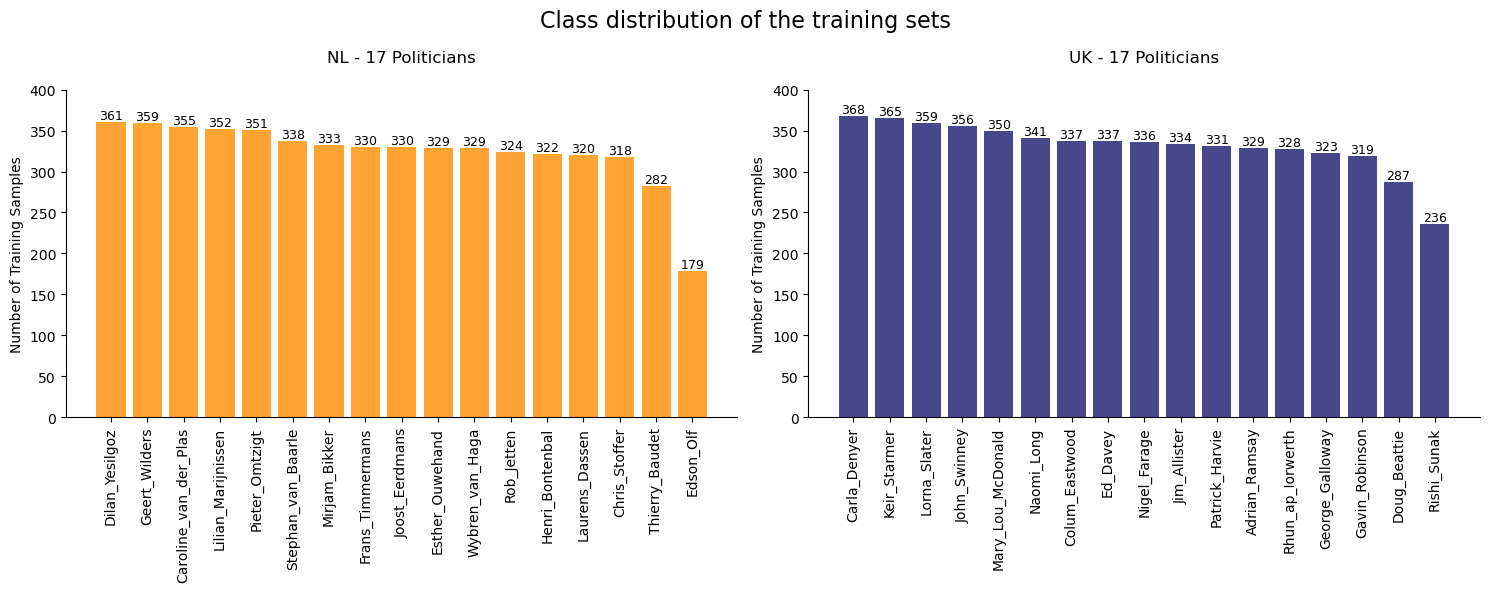

In [18]:
# Set up the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Class distribution of the training sets', fontsize=16)

colors = {
    'NL': "darkorange",
    'UK': "midnightblue"
}

for ax, country in zip([ax1, ax2], ['NL', 'UK']):
    class_counts = country_data[country]['embeddings']['politician'].value_counts().sort_values(ascending=False)
    bars = ax.bar(class_counts.index, class_counts.values, 
                 color=colors[country],
                 alpha=0.8)
    ax.grid(False)
    
    # Add count labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=9)
    
    # Customize the plot
    ax.set_title(f'{country} - {len(class_counts)} Politicians', pad=20)
    ax.set_ylabel('Number of Training Samples')
    ax.set_ylim(0, 400)
    ax.tick_params(axis='x', rotation=90)
    
    # Remove top and right spines
    sns.despine(ax=ax, right=True, top=True)

plt.tight_layout()
plt.show()

#### Inspect training clusters in 2D with t-SNE
This script takes approximately 2.25 minutes due to dimensionality reduction


Computing 2D clusters for NL
VGG-Face - 3307 samples
Facenet - 3307 samples
Facenet512 - 3307 samples
OpenFace - 3307 samples
ArcFace - 3307 samples
Dlib - 3307 samples
SFace - 3307 samples
face_recognition - 3307 samples

Computing 2D clusters for UK
VGG-Face - 3381 samples
Facenet - 3381 samples
Facenet512 - 3381 samples
OpenFace - 3381 samples
ArcFace - 3381 samples
Dlib - 3381 samples
SFace - 3381 samples
face_recognition - 3381 samples


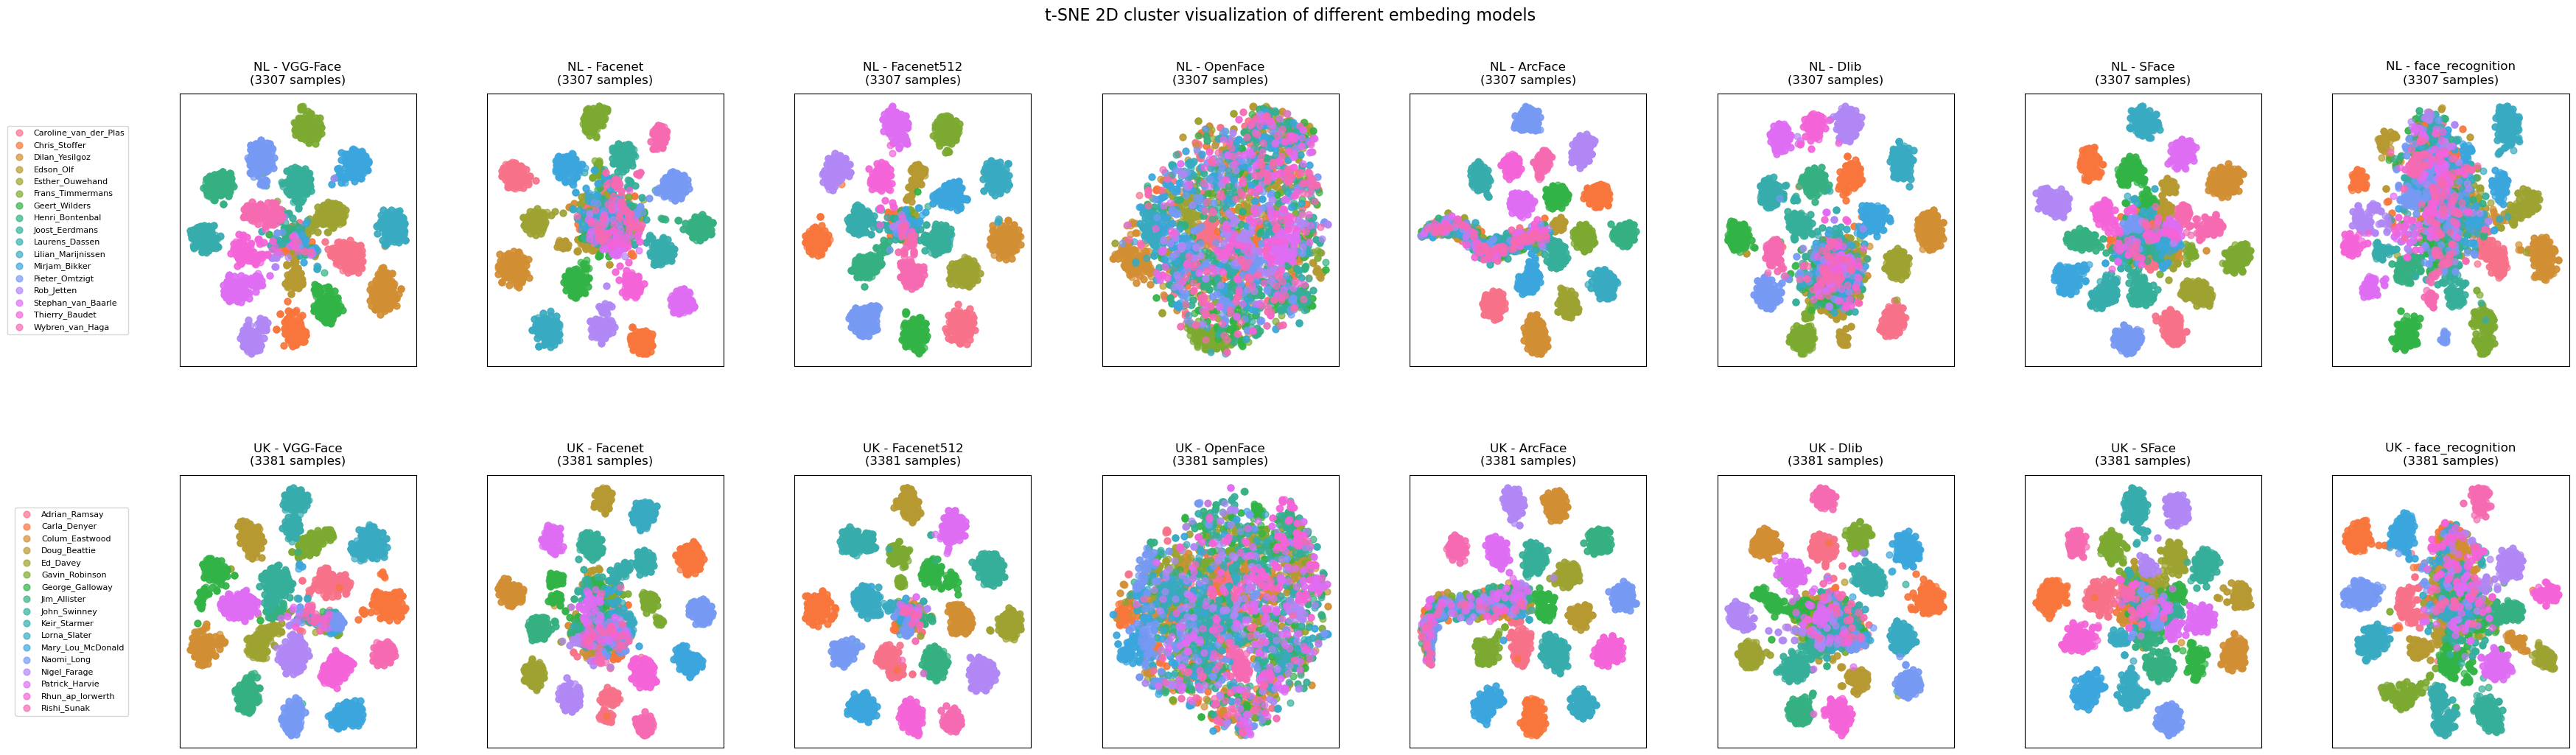

In [19]:
fig, axes = plt.subplots(2, 8, figsize=(35, 10))
fig.suptitle('t-SNE 2D cluster visualization of different embeding models', fontsize=16, y=1.02)

# Set the colors for the politicians
n_politicians = len(country_data['NL']['label_encoder'].classes_)
politician_palette = sns.color_palette("husl", n_politicians)

# Initialize t-SNE dimensionality reduction
tsne_params = {
    'n_components': 2,
    'perplexity': 30,
    'random_state': 2,
    'learning_rate': 50
}

# Compute clusters for the countries 
for country_idx, country in enumerate(countries):
    print(f'\nComputing 2D clusters for {country}')
    le = country_data[country]['label_encoder']
    
    for model_idx, model in enumerate(embedding_models):
        ax = axes[country_idx, model_idx]
        
        try:
            # Access the data
            embedder_data = country_data[country]['embedders'][model]
            X_train = np.vstack(embedder_data['train']['X'])
            y_train = embedder_data['train']['y']
            names = embedder_data['train']['politician']
            
            print(f"{model} - {len(X_train)} samples")
            
            # t-SNE
            tsne = TSNE(**tsne_params)
            X_2d = tsne.fit_transform(X_train)
            
            # Legend handles
            legend_handles = []
            unique_labels = np.unique(y_train)
            
            # Class plotting
            for label in unique_labels:
                mask = np.array(y_train) == label
                color = politician_palette[label]
                label_name = le.inverse_transform([label])[0]
                
                scatter = ax.scatter(X_2d[mask, 0], X_2d[mask, 1],
                                    color=color,
                                    label=label_name,
                                    alpha=0.7,
                                    s=40)
                if label != 99:  # Don't add unknown to legend if present
                    legend_handles.append(scatter)
            
            ax.set_title(f'{country} - {model}\n({len(X_train)} samples)', pad=10)
            
            # Add legend only to first column
            if model_idx == 0 and legend_handles:
                ax.legend(handles=legend_handles,
                         bbox_to_anchor=(-0.2, 0.5),
                         loc='center right',
                         fontsize=8)
            
        except Exception as e:
            ax.text(0.5, 0.5, f"Error:\n{str(e)}", 
                   ha='center', va='center', color='red')
            ax.set_title(f'{country} - {model} (Failed)', pad=10)
            print(f"Error with {model}: {str(e)}")
        
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()


Computing 2D clusters for NL
VGG-Face - 4096 dimensions
Facenet - 128 dimensions
Facenet512 - 512 dimensions
OpenFace - 128 dimensions
ArcFace - 512 dimensions
Dlib - 128 dimensions
SFace - 128 dimensions
face_recognition - 128 dimensions


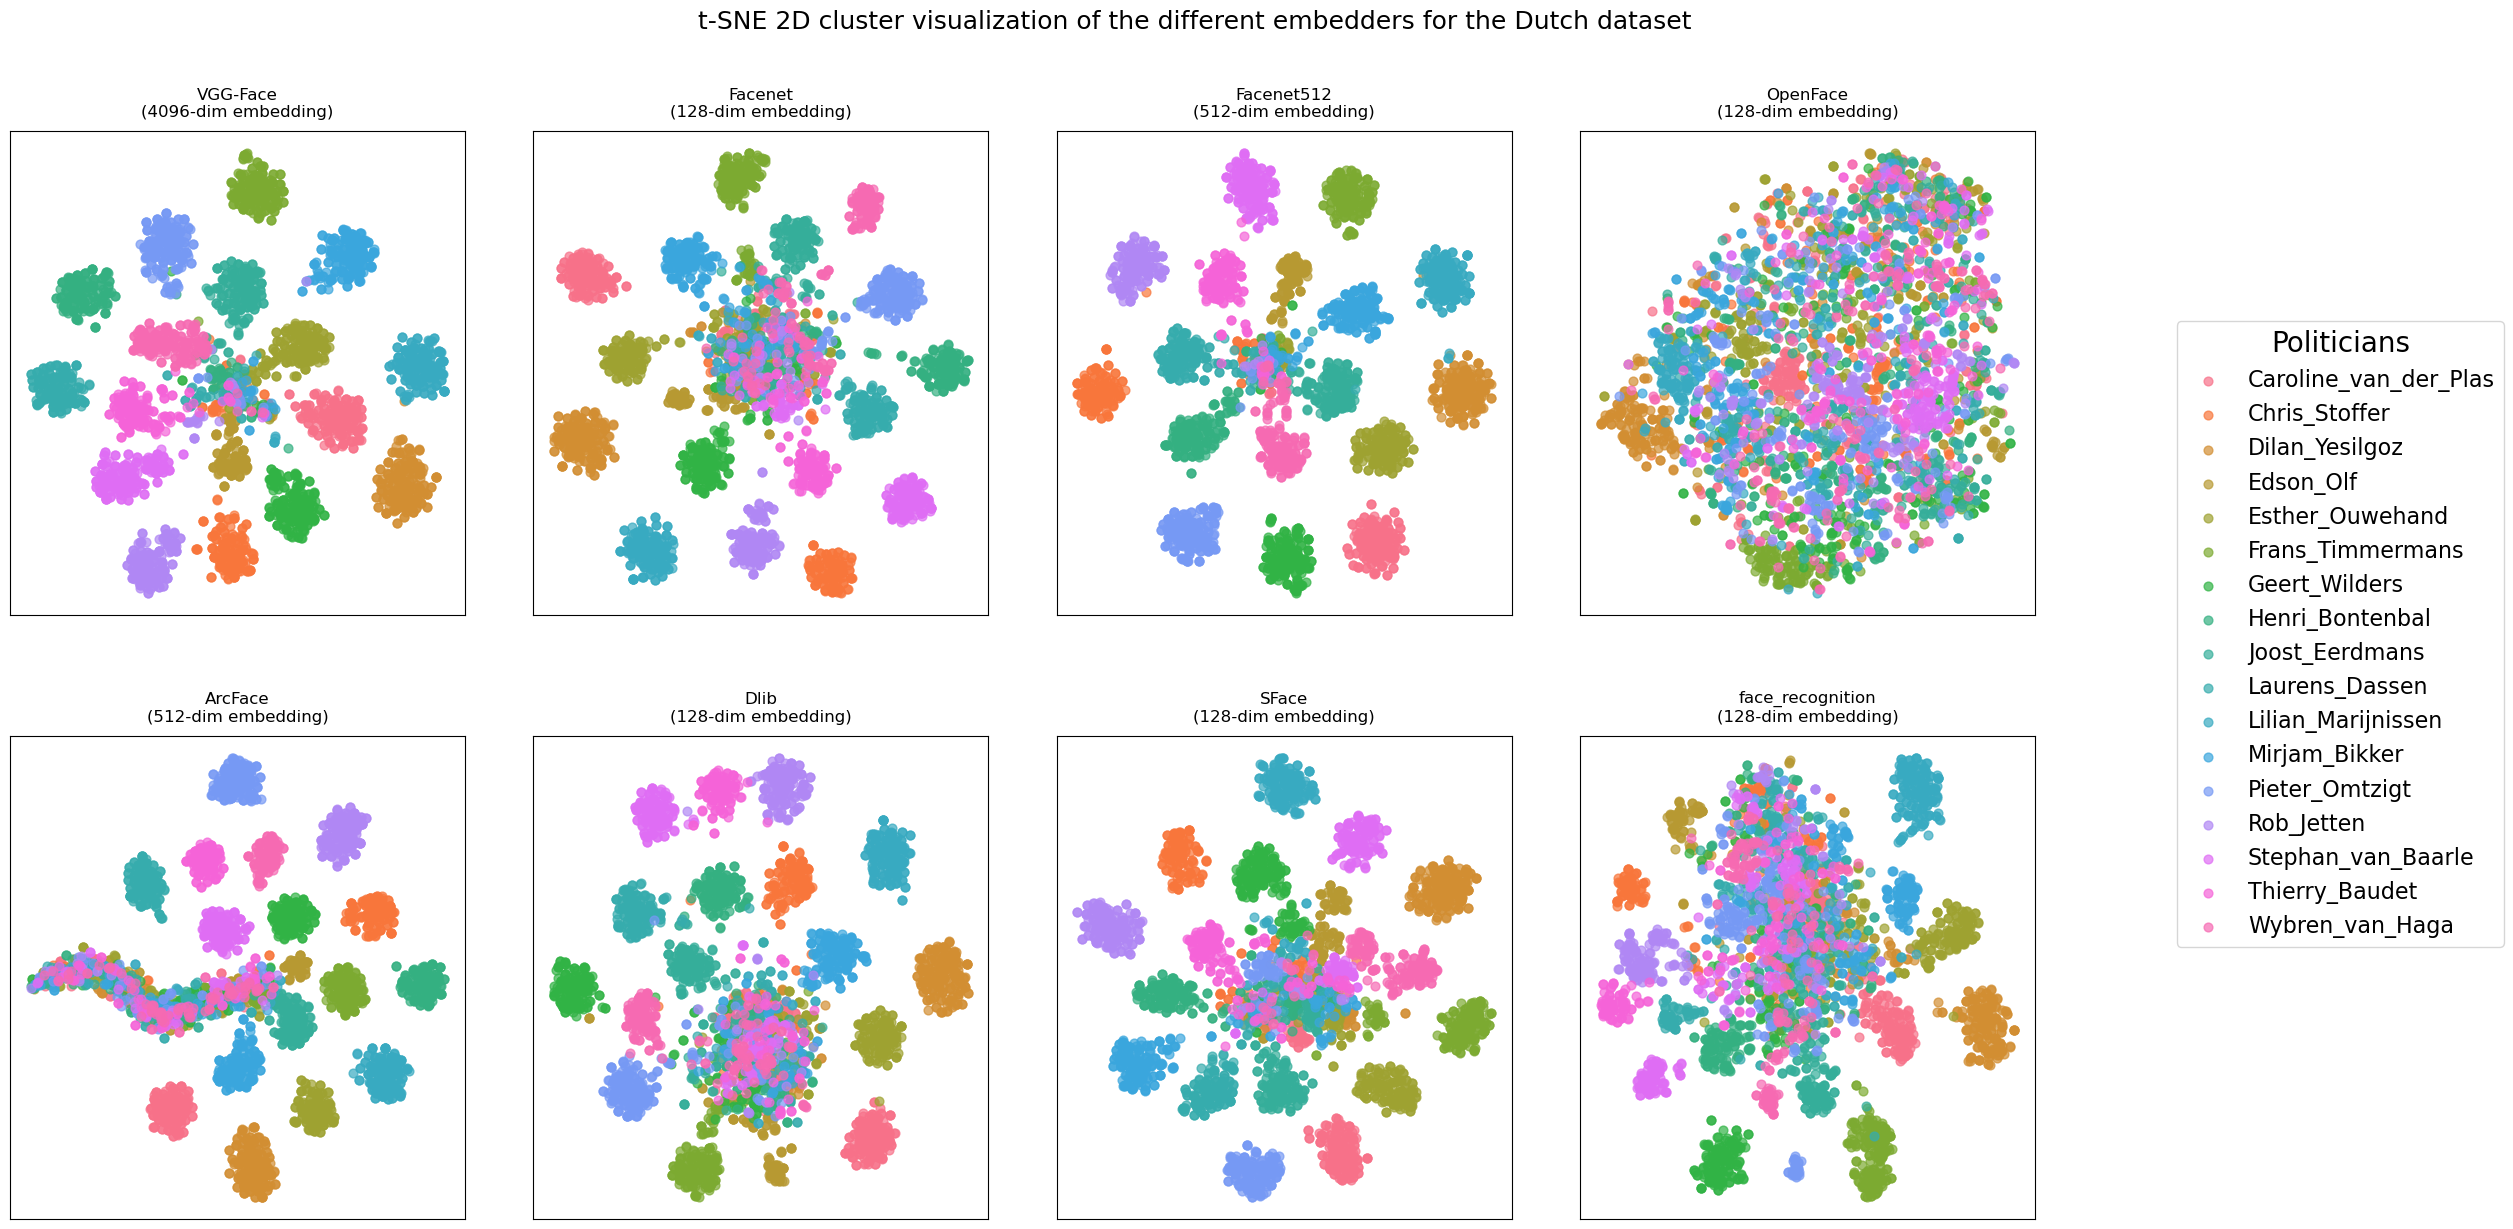

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
fig.suptitle('t-SNE 2D cluster visualization of the different embedders for the Dutch dataset', fontsize=18, y=1.02)

axes = axes.flatten()

n_politicians = len(country_data['NL']['label_encoder'].classes_)
politician_palette = sns.color_palette("husl", n_politicians)

tsne_params = {
    'n_components': 2,
    'perplexity': 30,
    'random_state': 2,
    'learning_rate': 50
}

print("\nComputing 2D clusters for NL")
le = country_data['NL']['label_encoder']

global_legend_handles = []
legend_labels = []

for model_idx, model in enumerate(embedding_models):
    if model_idx >= len(axes):  
        break

    ax = axes[model_idx]

    try:
        # Access the data
        embedder_data = country_data['NL']['embedders'][model]
        X_train = np.vstack(embedder_data['train']['X'])
        y_train = embedder_data['train']['y']

        dim = X_train.shape[1]  # embedding dimensionality
        print(f"{model} - {dim} dimensions")

        # t-SNE reduction
        tsne = TSNE(**tsne_params)
        X_2d = tsne.fit_transform(X_train)

        unique_labels = np.unique(y_train)

        # Plot per politician
        for label in unique_labels:
            mask = np.array(y_train) == label
            color = politician_palette[label]
            label_name = le.inverse_transform([label])[0]

            scatter = ax.scatter(
                X_2d[mask, 0], X_2d[mask, 1],
                color=color, label=label_name,
                alpha=0.7, s=40
            )

            # Collect legend info only once
            if label != 99 and label_name not in legend_labels:
                global_legend_handles.append(scatter)
                legend_labels.append(label_name)

        ax.set_title(f"{model}\n({dim}-dim embedding)", pad=10)

    except Exception as e:
        ax.text(0.5, 0.5, f"Error:\n{str(e)}",
                ha='center', va='center', color='red')
        ax.set_title(f"{model} (Failed)", pad=10)
        print(f"Error with {model}: {str(e)}")

    ax.set_xticks([])
    ax.set_yticks([])

# Remove unused subplots if fewer than 8 models
for j in range(model_idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Add one global legend spanning both rows
if global_legend_handles:
    fig.legend(
        handles=global_legend_handles,
        labels=legend_labels,
        loc='center right',
        bbox_to_anchor=(1.05, 0.5),
        fontsize=16,  # bigger font
        title="Politicians",
        title_fontsize=20
    )

plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.25, right=0.85)
plt.show()


## Final training

In [31]:
COUNTRY_DATA = country_data.copy()

COUNTRIES = ['NL', 'UK']

EMBEDDING_MODELS = [
    'VGG-Face', 
    'Facenet512', 
    'SFace',
    'Facenet', 
    'OpenFace', 
    'ArcFace', 
    #'DeepFace', 
    'Dlib', 
    'face_recognition'
]

# Col pointers
EMBEDDINGS_COLS = ['embedding_' + embedder for embedder in embedding_models]

CANDIDATE_THRESHOLDS = np.arange(0.50, 0.96, 0.025)  # range [0.5 (model is 50% sure) to 0.95 (model is 95% sure)]

UNKNOWN_LABEL = 99

#### Per class / global thresholding, with scaling (L2 normalizer)

In [32]:
# --------------------------------------------------
# Step 1: Hyperparameter search / Only politicians / Optimized for F1-score
# --------------------------------------------------
def find_best_svm_params(X_train, y_train, X_dev, y_dev, param_grid):
    best_score = -1
    best_params = None
    for params in ParameterGrid(param_grid):
        model = SVC(**params, probability=False, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_dev)
        score = f1_score(y_dev, y_pred, average='macro', zero_division=0)
        if score > best_score:
            best_score = score
            best_params = params
    return best_params

# --------------------------------------------------
# Step 2: Per - class threshold tuning / Optimized for F1-score that weighs recall 2*precision
# --------------------------------------------------
def tune_global_threshold(model, X_dev, y_dev, candidate_thresholds, unknown_label, known_classes, beta=2):
    probas = model.predict_proba(X_dev)
    classes = model.classes_
    
    best_score, best_tau = -1, 0.5
    for tau in candidate_thresholds:
        preds = []
        for row in probas:
            if row.max() >= tau:
                preds.append(classes[row.argmax()])
            else:
                preds.append(unknown_label)
        y_pred = np.array(preds)
        
        is_politician = np.isin(y_dev, known_classes).astype(int)
        is_pred_politician = (y_pred != unknown_label).astype(int)

        precision = precision_score(is_politician, is_pred_politician, zero_division=0)
        recall = recall_score(is_politician, is_pred_politician, zero_division=0)
        score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-8)
        
        if score > best_score:
            best_score, best_tau = score, tau
    
    # Global threshold
    thresholds = {c: best_tau for c in classes}
    return thresholds


def tune_class_thresholds(model, X_dev, y_dev, candidate_thresholds, unknown_label, known_classes, beta=2):
    probas = model.predict_proba(X_dev)
    classes = model.classes_
    thresholds = {}

    for i, c in enumerate(classes):
        best_score, best_tau = -1, 0.5
        for tau in candidate_thresholds:
            preds = []
            for row in probas:
                if row[i] >= tau:
                    preds.append(c)
                else:
                    preds.append(unknown_label)
            y_pred = np.array(preds)
                
            # Class-thresholding
            y_true_bin = (y_dev == c).astype(int)
            y_pred_bin = (y_pred == c).astype(int)

            precision = precision_score(y_true_bin, y_pred_bin, zero_division=0)
            recall = recall_score(y_true_bin, y_pred_bin, zero_division=0)
            score = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall + 1e-8)
            
            if score > best_score:
                best_score, best_tau = score, tau
            
        thresholds[c] = best_tau
    return thresholds

def predict_with_per_class_thresholds(model, X, thresholds, unknown_label):
    probas = model.predict_proba(X)
    classes = model.classes_
    preds = []
    for row in probas:
        best_idx = np.argmax(row)
        best_class = classes[best_idx]
        if row[best_idx] >= thresholds.get(best_class, 0.5):
            preds.append(best_class)
        else:
            preds.append(unknown_label)
            # Return predictions and their max probabilities
    return np.array(preds), probas

# --------------------------------------------------
# After training comes testing / Evaluate different metrics / Return a dict
# --------------------------------------------------

def evaluate_predictions(y_true, y_pred, scores, unknown_label, margin_threshold=None):
    is_actually_known = (y_true != unknown_label)
    is_predicted_known = (y_pred != unknown_label)
    is_actually_unknown = (y_true == unknown_label)
    is_predicted_unknown = (y_pred == unknown_label)

    max_scores = scores.max(axis=1)
    margins = np.sort(scores, axis=1)[:, -1] - np.sort(scores, axis=1)[:, -2] if scores.shape[1] > 1 else max_scores

    # --- Layer 1: Politicians vs Unknown ---
    politician_vs_unknown = {
        'politician_vs_unknown_f1': f1_score(is_actually_known, is_predicted_known, zero_division=0),
        'politician_vs_unknown_precision': precision_score(is_actually_known, is_predicted_known, zero_division=0),
        'politician_vs_unknown_recall': recall_score(is_actually_known, is_predicted_known, zero_division=0),
        'unknown_f1': f1_score(is_actually_unknown, is_predicted_unknown, zero_division=0),
        'unknown_precision': precision_score(is_actually_unknown, is_predicted_unknown, zero_division=0),
        'unknown_recall': recall_score(is_actually_unknown, is_predicted_unknown, zero_division=0),
    }

    # --- Layer 2: Intra-politician discrimination (ignore unknowns) ---
    mask_known = (y_true != unknown_label)
    if mask_known.sum() > 0:
        intra_politician = {
            'intra_politician_f1': f1_score(y_true[mask_known], y_pred[mask_known], average='macro', zero_division=0),
            'intra_politician_precision': precision_score(y_true[mask_known], y_pred[mask_known], average='macro', zero_division=0),
            'intra_politician_recall': recall_score(y_true[mask_known], y_pred[mask_known], average='macro', zero_division=0),
        }
    else:
        intra_politician = {
            'intra_politician_f1': 0,
            'intra_politician_precision': 0,
            'intra_politician_recall': 0,
        }

    # --- Global multiclass metrics (incl. unknown) ---
    multiclass = {
        'multiclass_f1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'multiclass_precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'multiclass_recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
    }

    # --- Summary statistics ---
    stats = {
        'n_politician_true': sum(is_actually_known),
        'n_politician_pred': sum(is_predicted_known),
        'n_unknown_true': sum(is_actually_unknown),
        'n_unknown_pred': sum(is_predicted_unknown),
        'frac_unknown_pred': sum(is_predicted_unknown) / len(y_true) if len(y_true) > 0 else 0,
        'frac_unknown_true': sum(is_actually_unknown) / len(y_true) if len(y_true) > 0 else 0,
        'mean_max_score': np.mean(max_scores),
        'median_max_score': np.median(max_scores),
        'mean_margin': np.mean(margins),
        'median_margin': np.median(margins)
    }

    return {**politician_vs_unknown, **intra_politician, **multiclass, **stats}

# --------------------------------------------------
# Step 3: Complete pipeline: training, threshold tuning, evaluation
# --------------------------------------------------
def evaluate_models_two_stage(country_data, countries, embedders, unknown_label,
                                candidate_thresholds, thresholding_type):
    all_results = []
    all_thresholds = {}

    for country in countries:
        all_thresholds[country] = {}

        for embedder_name in embedders:
            print(f'Country {country} - embedder {embedder_name}')

            if embedder_name not in country_data[country]['embedders']:
                continue

            try:
                X_train = np.vstack(country_data[country]['embedders'][embedder_name]['train']['X'])
                y_train = np.array(country_data[country]['embedders'][embedder_name]['train']['y'])
                X_dev = np.vstack(country_data[country]['embedders'][embedder_name]['dev']['X'])
                y_dev = np.array(country_data[country]['embedders'][embedder_name]['dev']['y'])
                X_test = np.vstack(country_data[country]['embedders'][embedder_name]['test']['X'])
                y_test = np.array(country_data[country]['embedders'][embedder_name]['test']['y'])

                # For SVM hyperparameter tuning, only use politicians and no unknowns 
                dev_mask = (y_dev != unknown_label)
                X_dev_known = X_dev[dev_mask]
                y_dev_known = y_dev[dev_mask]

                known_classes = np.unique(y_dev_known)

                param_grid = {
                    'C': [0.1, 1],
                    'gamma': ['scale', 'auto'],
                    'class_weight': [None, 'balanced', {cls: 2 for cls in known_classes}],
                    'kernel': ['rbf']
                }

                if X_train.shape[0] == 0 or X_dev_known.shape[0] == 0:
                    print(f"Skipping {country}-{embedder_name}: not enough known data")
                    continue

                # Preprocess: normalize embeddings
                scaler = Normalizer(norm='l2')
                X_train = scaler.fit_transform(X_train)
                X_dev = scaler.transform(X_dev)
                X_test = scaler.transform(X_test)

                # Step 1: hyperparameter tuning
                best_params = find_best_svm_params(X_train, y_train, X_dev_known, y_dev_known, param_grid)
                print(f"Best params: {best_params}")

                # Train
                final_model = SVC(**best_params, probability=True, random_state=42)
                final_model.fit(X_train, y_train)

                # Step 2: threshold tuning (with unknowns)
                if thresholding_type == 'global_thresholding':
                    thresholds = tune_global_threshold(final_model, X_dev, y_dev, candidate_thresholds, unknown_label, known_classes)
                elif thresholding_type == 'class_thresholding':
                    thresholds = tune_class_thresholds(final_model, X_dev, y_dev, candidate_thresholds, unknown_label, known_classes, beta=2)
                else:
                    raise ValueError("thresholding_type must be 'global_thresholding' or 'class_thresholding'")
                    
                all_thresholds[country][embedder_name] = thresholds

                # Evaluate with development set (politicians + unknowns)
                y_dev_pred, dev_scores = predict_with_per_class_thresholds(
                    final_model, X_dev, thresholds, unknown_label
                )
                dev_metrics = evaluate_predictions(y_dev, y_dev_pred, dev_scores, unknown_label)
                dev_metrics.update({
                    'country': country,
                    'embedder': embedder_name,
                    'params': str(best_params),
                    'C': best_params.get('C', None),
                    'gamma': best_params.get('gamma', None),
                    'class_weight': best_params.get('class_weight', None),
                    'kernel': best_params.get('kernel', None),
                    'split': 'dev'
                })
                all_results.append(dev_metrics)

                # Test evaluation
                y_test_pred, test_scores = predict_with_per_class_thresholds(
                    final_model, X_test, thresholds, unknown_label
                )
                test_metrics = evaluate_predictions(y_test, y_test_pred, test_scores, unknown_label)
                test_metrics.update({
                    'country': country,
                    'embedder': embedder_name,
                    'params': str(best_params),
                    'C': best_params.get('C', None),
                    'gamma': best_params.get('gamma', None),
                    'class_weight': best_params.get('class_weight', None),
                    'kernel': best_params.get('kernel', None),
                    'split': 'test'
                })
                all_results.append(test_metrics)

            except Exception as e:
                print(f"ERROR {country}-{embedder_name}: {e}")
                continue

    if not all_results:
        return pd.DataFrame(), all_thresholds

    df = pd.DataFrame(all_results)

    cols_order = [
    'country','embedder','split','params','C','gamma','class_weight','kernel',

    # --- Layer 1: Politicians vs Unknown ---
    'politician_vs_unknown_f1','politician_vs_unknown_precision','politician_vs_unknown_recall',
    'unknown_f1','unknown_precision','unknown_recall',

    # --- Layer 2: Intra-politician ---
    'intra_politician_f1','intra_politician_precision','intra_politician_recall',

    # --- Layer 3: Multiclass (incl. unknown) ---
    'multiclass_f1','multiclass_precision','multiclass_recall',

    # --- Stats ---
    'n_politician_true','n_politician_pred','n_unknown_true','n_unknown_pred',
    'frac_unknown_pred','frac_unknown_true',
    'mean_max_score','median_max_score','mean_margin','median_margin'
    ]
    existing_cols = [c for c in cols_order if c in df.columns]

    return df[existing_cols], all_thresholds

In [33]:
# Class thresholding
class_results, class_thresholds = evaluate_models_two_stage(
    COUNTRY_DATA, COUNTRIES, EMBEDDING_MODELS,
    UNKNOWN_LABEL, CANDIDATE_THRESHOLDS,
    thresholding_type='class_thresholding'
)

# Global thresholding
global_results, global_thresholds = evaluate_models_two_stage(
    COUNTRY_DATA, COUNTRIES, EMBEDDING_MODELS,
    UNKNOWN_LABEL, CANDIDATE_THRESHOLDS,
    thresholding_type='global_thresholding'
)

Country NL - embedder VGG-Face
Best params: {'C': 1, 'class_weight': {np.int64(0): 2, np.int64(1): 2, np.int64(2): 2, np.int64(3): 2, np.int64(4): 2, np.int64(5): 2, np.int64(6): 2, np.int64(7): 2, np.int64(8): 2, np.int64(9): 2, np.int64(10): 2, np.int64(11): 2, np.int64(12): 2, np.int64(13): 2, np.int64(14): 2, np.int64(15): 2, np.int64(16): 2}, 'gamma': 'scale', 'kernel': 'rbf'}
Country NL - embedder Facenet512
Best params: {'C': 1, 'class_weight': {np.int64(0): 2, np.int64(1): 2, np.int64(2): 2, np.int64(3): 2, np.int64(4): 2, np.int64(5): 2, np.int64(6): 2, np.int64(7): 2, np.int64(8): 2, np.int64(9): 2, np.int64(10): 2, np.int64(11): 2, np.int64(12): 2, np.int64(13): 2, np.int64(14): 2, np.int64(15): 2, np.int64(16): 2}, 'gamma': 'auto', 'kernel': 'rbf'}
Country NL - embedder SFace
Best params: {'C': 1, 'class_weight': {np.int64(0): 2, np.int64(1): 2, np.int64(2): 2, np.int64(3): 2, np.int64(4): 2, np.int64(5): 2, np.int64(6): 2, np.int64(7): 2, np.int64(8): 2, np.int64(9): 2, np

In [ ]:
class_results['threshold'] = 'class'
global_results['threshold'] = 'global'

In [49]:
all_threshold_results = pd.concat([class_results, global_results])
all_threshold_results.drop(columns=['class_weight'], inplace=True)

In [50]:
threshold_data = []

for country, embedders in global_thresholds.items():
    for embedder, classes in embedders.items():
        row = {
            'country': country,
            'embedder': embedder,
            'threshold': 'global'
        }
        # Add class thresholds (all same value for global)
        for class_id, threshold_value in classes.items():
            row[f't_class_{class_id:02d}'] = float(threshold_value)
        threshold_data.append(row)

for country, embedders in class_thresholds.items():
    for embedder, classes in embedders.items():
        row = {
            'country': country,
            'embedder': embedder,
            'threshold': 'class'
        }
        for class_id, threshold_value in classes.items():
            row[f't_class_{class_id:02d}'] = float(threshold_value)
        threshold_data.append(row)

threshold_df = pd.DataFrame(threshold_data)
threshold_df_cols = ['country', 'embedder', 'threshold'] + [col for col in threshold_df.columns if col.startswith('t_class_')]
threshold_df = threshold_df[threshold_df_cols]

In [51]:
all_threshold_results.to_parquet('datasets/NL-UK__train_dev_test_results_global_and_class_t.parquet')
threshold_df.to_parquet('datasets/NL-UK__global_and_class_t_values.parquet')

In [4]:
class_thresholds_dict

{'NL': {'VGG-Face': {np.int64(0): np.float64(0.55),
   np.int64(1): np.float64(0.7750000000000002),
   np.int64(2): np.float64(0.6750000000000002),
   np.int64(3): np.float64(0.6000000000000001),
   np.int64(4): np.float64(0.9000000000000004),
   np.int64(5): np.float64(0.6000000000000001),
   np.int64(6): np.float64(0.55),
   np.int64(7): np.float64(0.6500000000000001),
   np.int64(8): np.float64(0.8000000000000003),
   np.int64(9): np.float64(0.7500000000000002),
   np.int64(10): np.float64(0.5),
   np.int64(11): np.float64(0.7750000000000002),
   np.int64(12): np.float64(0.9000000000000004),
   np.int64(13): np.float64(0.6500000000000001),
   np.int64(14): np.float64(0.7750000000000002),
   np.int64(15): np.float64(0.6500000000000001),
   np.int64(16): np.float64(0.7000000000000002)},
  'Facenet512': {np.int64(0): np.float64(0.6000000000000001),
   np.int64(1): np.float64(0.6000000000000001),
   np.int64(2): np.float64(0.6250000000000001),
   np.int64(3): np.float64(0.95000000000000

In [2]:
VGG_class_thresholds_dict = {
    'NL': {
        'VGG-Face': {
            np.int64(0): np.float64(0.55),
            np.int64(1): np.float64(0.7750000000000002),
            np.int64(2): np.float64(0.6750000000000002),
            np.int64(3): np.float64(0.6000000000000001),
            np.int64(4): np.float64(0.9000000000000004),
            np.int64(5): np.float64(0.6000000000000001),
            np.int64(6): np.float64(0.55),
            np.int64(7): np.float64(0.6500000000000001),
            np.int64(8): np.float64(0.8000000000000003),
            np.int64(9): np.float64(0.7500000000000002),
            np.int64(10): np.float64(0.5),
            np.int64(11): np.float64(0.7750000000000002),
            np.int64(12): np.float64(0.9000000000000004),
            np.int64(13): np.float64(0.6500000000000001),
            np.int64(14): np.float64(0.7750000000000002),
            np.int64(15): np.float64(0.6500000000000001),
            np.int64(16): np.float64(0.7000000000000002)
            }
          },
      'UK': {
          'VGG-Face': {
              np.int64(0): np.float64(0.525),
              np.int64(1): np.float64(0.7750000000000002),
              np.int64(2): np.float64(0.6250000000000001),
              np.int64(3): np.float64(0.6750000000000002),
              np.int64(4): np.float64(0.5750000000000001),
              np.int64(5): np.float64(0.525),
              np.int64(6): np.float64(0.5750000000000001),
              np.int64(7): np.float64(0.7500000000000002),
              np.int64(8): np.float64(0.525),
              np.int64(9): np.float64(0.5750000000000001),
              np.int64(10): np.float64(0.55),
              np.int64(11): np.float64(0.5),
              np.int64(12): np.float64(0.6000000000000001),
              np.int64(13): np.float64(0.525),
              np.int64(14): np.float64(0.7000000000000002),
              np.int64(15): np.float64(0.5),
              np.int64(16): np.float64(0.6000000000000001)
              }
            }
      }
with open('datasets/UK-NL_VGG-Face_country_class_thresholds.pkl', 'wb') as f:
    pickle.dump(VGG_class_thresholds_dict, f)

### Visualize results

In [2]:
results_df = pd.read_parquet('datasets/NL-UK__train_dev_test_results_global_and_class_t.parquet')

In [3]:
test_results_nl = results_df[(results_df['country'] == 'NL') & (results_df['split'] == 'test') & (results_df['threshold'] == 'class')]
test_results_uk = results_df[(results_df['country'] == 'UK') & (results_df['split'] == 'test') & (results_df['threshold'] == 'class')]

In [4]:
test_results_uk

,country,embedder,split,params,C,gamma,kernel,politician_vs_unknown_f1,politician_vs_unknown_precision,politician_vs_unknown_recall,...,n_politician_pred,n_unknown_true,n_unknown_pred,frac_unknown_pred,frac_unknown_true,mean_max_score,median_max_score,mean_margin,median_margin,threshold
17,UK,VGG-Face,test,"{'C': 1, 'class_weight': {np.int64(0): 2, np.i...",1,scale,rbf,0.945148,0.938810,0.951572,...,1193,2189,2173,0.645573,0.650327,0.505495,0.356859,0.402694,0.200502,class
19,UK,Facenet512,test,"{'C': 1, 'class_weight': {np.int64(0): 2, np.i...",1,auto,rbf,0.873023,0.932432,0.820731,...,1036,2189,2330,0.692216,0.650327,0.541264,0.448999,0.409733,0.275225,class
21,UK,SFace,test,"{'C': 1, 'class_weight': {np.int64(0): 2, np.i...",1,auto,rbf,0.879235,0.899556,0.859813,...,1125,2189,2241,0.665775,0.650327,0.492315,0.355355,0.373105,0.186049,class
23,UK,Facenet,test,"{'C': 1, 'class_weight': {np.int64(0): 2, np.i...",1,auto,rbf,0.837425,0.920570,0.768054,...,982,2189,2384,0.708259,0.650327,0.492122,0.375073,0.355677,0.196671,class
25,UK,OpenFace,test,"{'C': 1, 'class_weight': {np.int64(0): 2, np.i...",1,scale,rbf,0.562734,0.626694,0.510620,...,959,2189,2407,0.715092,0.650327,0.429931,0.373308,0.273295,0.183842,class
27,UK,ArcFace,test,"{'C': 1, 'class_weight': {np.int64(0): 2, np.i...",1,auto,rbf,0.347826,0.995984,0.210705,...,249,2189,3117,0.926025,0.650327,0.233588,0.147198,0.117779,0.020905,class
29,UK,Dlib,test,"{'C': 1, 'class_weight': {np.int64(0): 2, np.i...",1,scale,rbf,0.796708,0.772546,0.822430,...,1253,2189,2113,0.627748,0.650327,0.532112,0.447428,0.395361,0.259510,class
31,UK,face_recognition,test,"{'C': 1, 'class_weight': {np.int64(0): 2, np.i...",1,scale,rbf,0.762226,0.756485,0.768054,...,1195,2189,2171,0.644979,0.650327,0.563240,0.497054,0.425221,0.316583,class


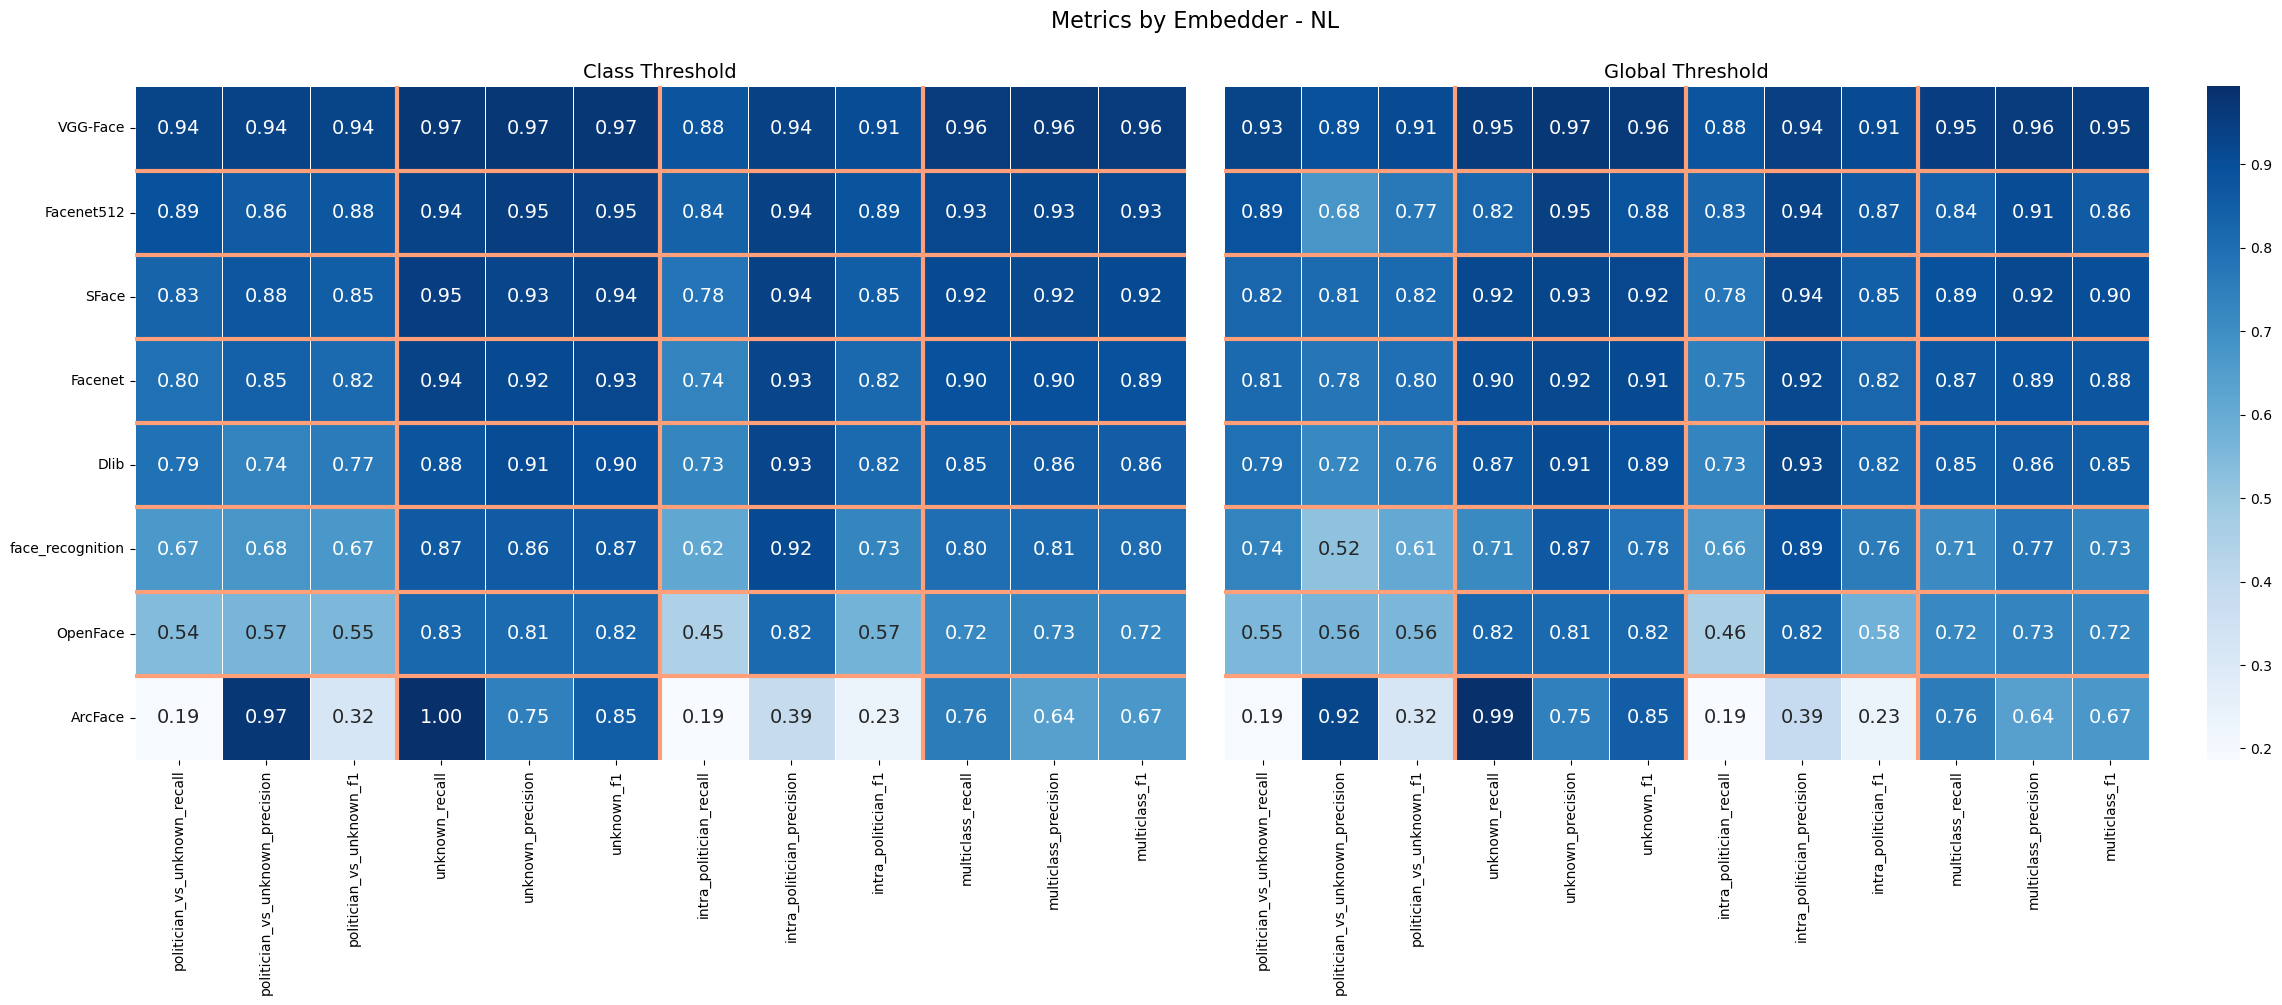

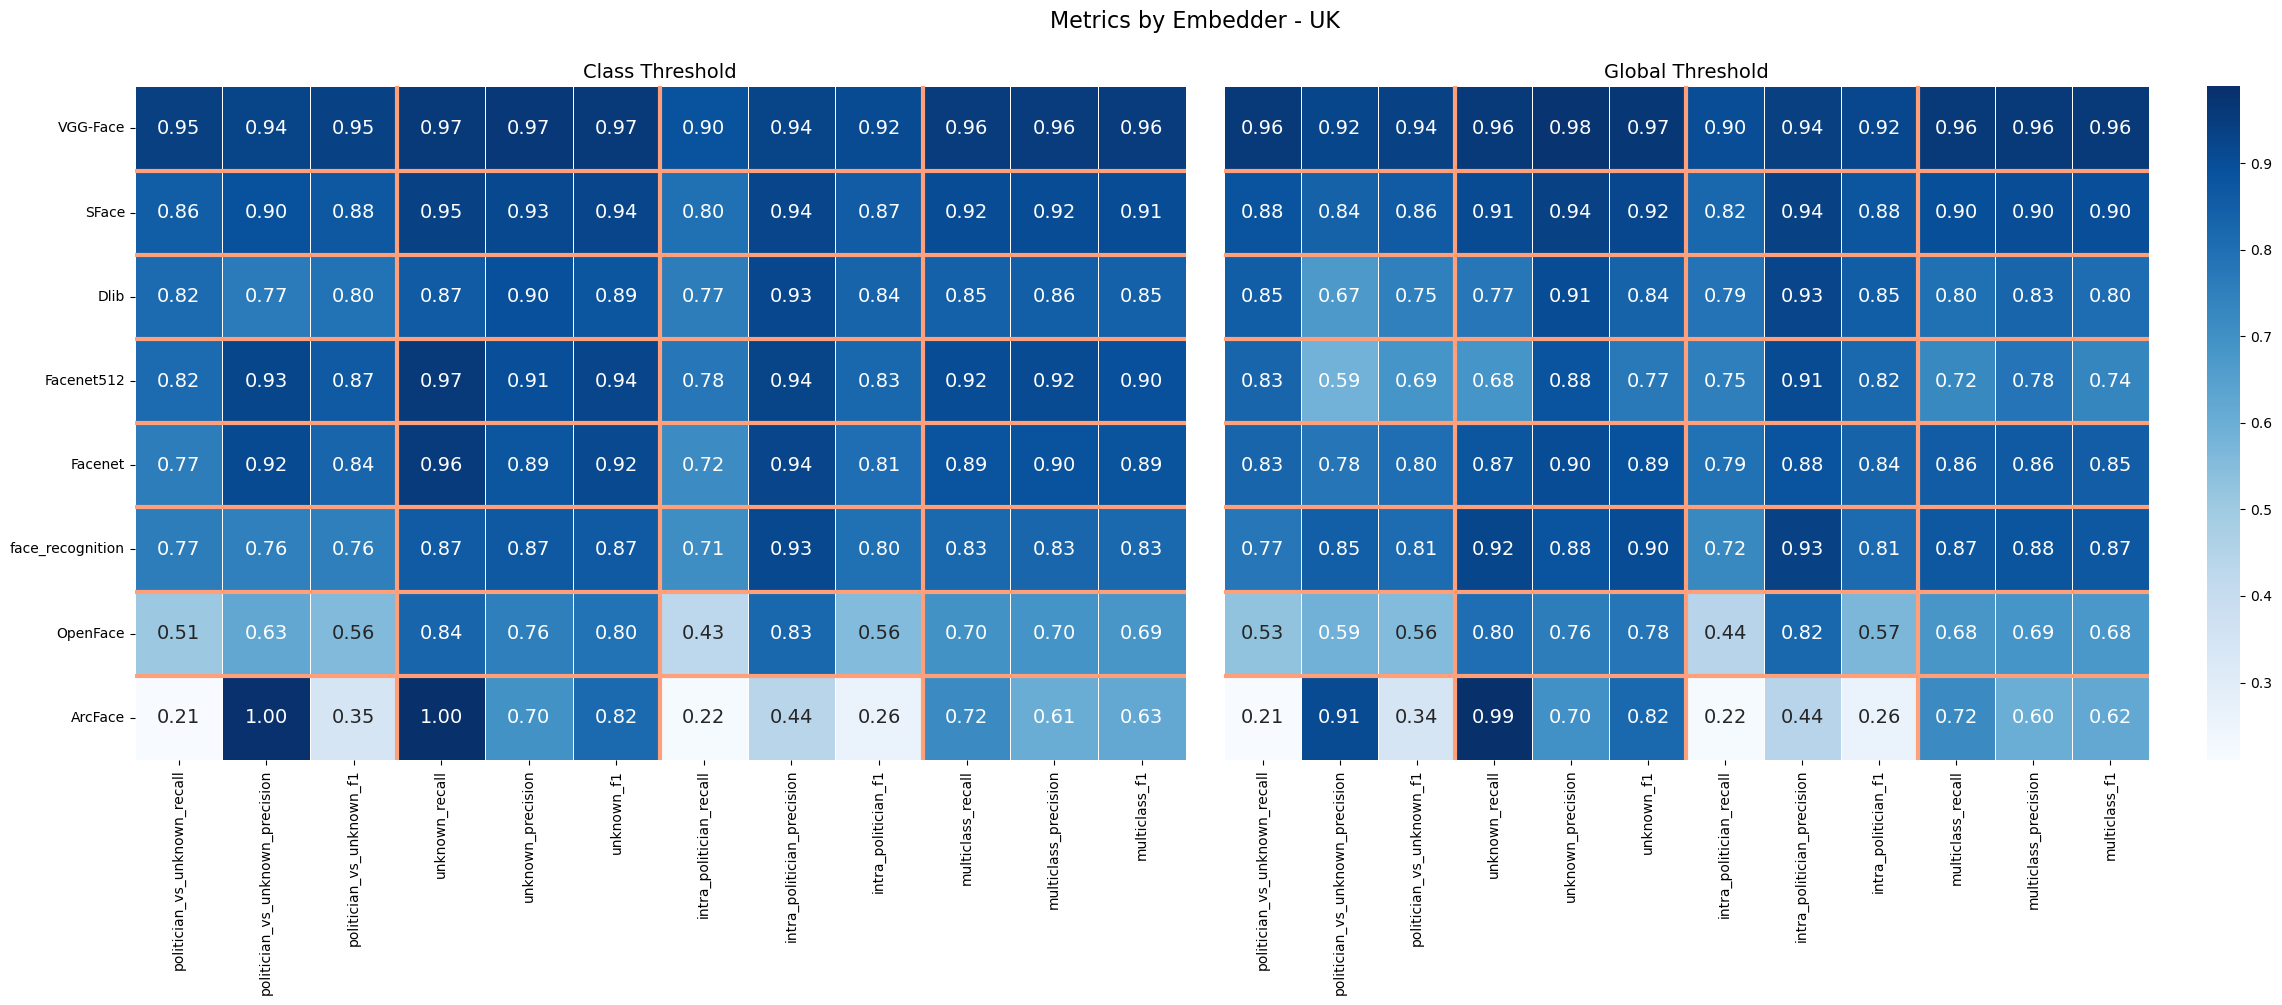

In [111]:
heatmap_metrics = ['politician_vs_unknown_recall', 'politician_vs_unknown_precision', 'politician_vs_unknown_f1', 
            'unknown_recall', 'unknown_precision', 'unknown_f1', 
            'intra_politician_recall',  'intra_politician_precision', 'intra_politician_f1',
            'multiclass_recall', 'multiclass_precision', 'multiclass_f1']

def print_heatmap_metrics(df, country, metrics):
    df_country = df[(df['country'] == country) & (df['split'] == 'test')]
    
    df_class = df_country[df_country['threshold'] == 'class']
    df_global = df_country[df_country['threshold'] == 'global']
    
    df_class_sorted = df_class.sort_values('politician_vs_unknown_recall', ascending=False)
    df_global_sorted = df_global.sort_values('politician_vs_unknown_recall', ascending=False)
    
    results_class = df_class_sorted.set_index('embedder')[metrics]
    results_global = df_global_sorted.set_index('embedder')[metrics]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10), gridspec_kw={'width_ratios': [1, 1.1]})
    
    sns.heatmap(results_class, annot=True, cmap="Blues", fmt=".2f", ax=ax1, cbar=False,
                linewidths=0.5, linecolor='white', annot_kws={'size': 14})
    ax1.set_title("Class Threshold", fontsize=14)
    ax1.set_ylabel('')  
    ax1.tick_params(axis='y', labelrotation=0)

    sns.heatmap(results_global, annot=True, cmap="Blues", fmt=".2f", ax=ax2, 
                cbar_kws={'location': 'right'},
                linewidths=0.5, linecolor='white', annot_kws={'size': 14})
    ax2.set_title("Global Threshold", fontsize=14)
    ax2.set_ylabel('') 
    ax2.set_yticks([]) 
    
    for ax in [ax1, ax2]:
        for i in range(3, len(metrics), 3):
            ax.axvline(x=i, color='lightsalmon', linewidth=3)

    for ax in [ax1, ax2]:
        for i in range(1, len(results_class)):
            ax.axhline(y=i, color='lightsalmon', linewidth=3)
        
    plt.suptitle(f"Metrics by Embedder - {country}", fontsize=16, y=1)
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.035)
    plt.savefig(f'../z__visual-outputs-matplotlib/{country}_global_class_test_results_heatmap.pdf', format='pdf', bbox_inches='tight')
    plt.show()

for country in COUNTRIES:
    print_heatmap_metrics(df=results_df, country=country, metrics=heatmap_metrics)

In [77]:
df = results_df.copy()
df = df[(df['country'] == 'NL') & (df['split'] == 'test') & (df['threshold'] == 'class')]

In [78]:
df

,country,embedder,split,params,C,gamma,kernel,politician_vs_unknown_f1,politician_vs_unknown_precision,politician_vs_unknown_recall,...,n_politician_pred,n_unknown_true,n_unknown_pred,frac_unknown_pred,frac_unknown_true,mean_max_score,median_max_score,mean_margin,median_margin,threshold
1,NL,VGG-Face,test,"{'C': 1, 'class_weight': {np.int64(0): 2, np.i...",1,scale,rbf,0.937008,0.937828,0.936189,...,1142,2743,2745,0.706200,0.705686,0.538076,0.436002,0.425583,0.279402,class
3,NL,Facenet512,test,"{'C': 1, 'class_weight': {np.int64(0): 2, np.i...",1,auto,rbf,0.877253,0.861720,0.893357,...,1186,2743,2701,0.694880,0.705686,0.551561,0.470280,0.427637,0.319299,class
5,NL,SFace,test,"{'C': 1, 'class_weight': {np.int64(0): 2, np.i...",1,auto,rbf,0.854839,0.876838,0.833916,...,1088,2743,2799,0.720093,0.705686,0.502168,0.390785,0.372553,0.214976,class
7,NL,Facenet,test,"{'C': 1, 'class_weight': {np.int64(0): 2, np.i...",1,auto,rbf,0.819982,0.845083,0.796329,...,1078,2743,2809,0.722665,0.705686,0.455519,0.329776,0.331316,0.165257,class
9,NL,OpenFace,test,"{'C': 1, 'class_weight': {np.int64(0): 2, np.i...",1,scale,rbf,0.554764,0.565336,0.544580,...,1102,2743,2785,0.716491,0.705686,0.423623,0.365568,0.259391,0.172804,class
11,NL,ArcFace,test,"{'C': 1, 'class_weight': {np.int64(0): 2, np.i...",1,auto,rbf,0.321168,0.973451,0.192308,...,226,2743,3661,0.941857,0.705686,0.259745,0.217380,0.130776,0.072504,class
13,NL,Dlib,test,"{'C': 1, 'class_weight': {np.int64(0): 2, np.i...",1,scale,rbf,0.765599,0.739414,0.793706,...,1228,2743,2659,0.684075,0.705686,0.511690,0.427979,0.365374,0.232968,class
15,NL,face_recognition,test,"{'C': 1, 'class_weight': {np.int64(0): 2, np.i...",1,scale,rbf,0.673703,0.677876,0.669580,...,1130,2743,2757,0.709287,0.705686,0.509884,0.439524,0.353984,0.243404,class
